# Minimization problems with limited resources
## Scalability analysis

This notebook will hold several scalability experiments which will involve the sphere function, the rosenbrock function and the rotated ellipsoids. In here, we consider a scaling problem for which the resources are limited and fixed (i.e. fixed population size and maximum number of generations)

### Setup

In [1]:
import sys
CODEBASE = "./codebase"
if CODEBASE not in sys.path:
    sys.path.append(CODEBASE)

from cooperative_evolution_optimizers import GrayBoxOptimizer, BlackBoxOptimizer
from differential_evolution import DifferentialEvolution as DE
from evolution_strategies import EvolutionStrategies as ES
from particle_swarm_optimization import ParticleSwarmOptimization as PSO
from particle_swarm_optimization import PSOInteractions

from fitness_functions import FunctionFactory
get_sphere = FunctionFactory.get_sphere
get_rosenbrock = FunctionFactory.get_rosenbrock

import numpy as np
import matplotlib.pyplot as plt
from time import time

# Compare normal BBO with CC BBO and CC GBO using DE for sphere
Species of length 2, increasing number of functions

K 1
	0 1 2 3 4 5 6 7 8 9 
K 2
	0 1 2 3 4 5 6 7 8 9 
K 3
	0 1 2 3 4 5 6 7 8 9 
K 4
	0 1 2 3 4 5 6 7 8 9 
K 5
	0 1 2 3 4 5 6 7 8 9 
K 6
	0 1 2 3 4 5 6 7 8 9 ### Dropping standard DE ###

K 7
	0 1 2 3 4 5 6 7 8 9 
K 8
	0 1 2 3 4 5 6 7 8 9 
K 9
	0 1 2 3 4 5 6 7 8 9 
K 10
	0 1 2 3 4 5 6 7 8 9 


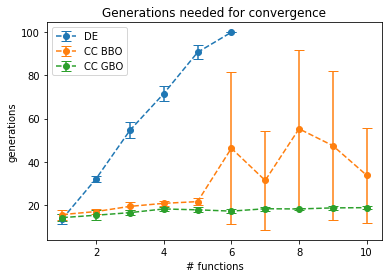

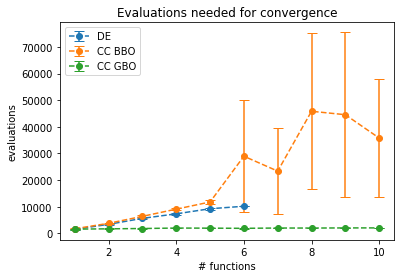

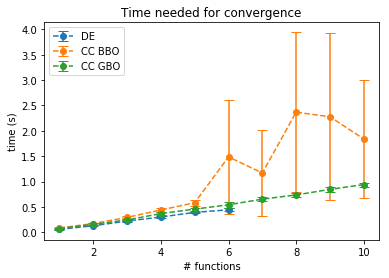

In [19]:
### Initialize some settings of the experiment
sphere = get_sphere()
subL = 2
VTR = pow(10, -5)
# repeat each experiment N times
N = 10
# number of functions is increasing
Kmax = 10
Ks = list(range(1, Kmax+1))
pop_size = 100
max_generations = 100
# arguments for the DE
args = {"population_size": pop_size, "crossover_probability": 0.25,
                     "f_weight": 0.1}
### Create arrays to store all of the partial results for later plotting
times = np.zeros((len(Ks), N))
times_gbo = np.zeros((len(Ks), N))
times_bbo = np.zeros((len(Ks), N))
evals = np.zeros((len(Ks), N))
evals_gbo = np.zeros((len(Ks), N))
evals_bbo = np.zeros((len(Ks), N))
gens = np.zeros((len(Ks), N))
gens_gbo = np.zeros((len(Ks), N))
gens_bbo = np.zeros((len(Ks), N))
# to save some time, check up until what point the algorithms have been solving the problems,
# so that we don't run the harder experiments if they failed the easier ones
# also only plot up until the first big failure
success_idx = 0
success_idx_gbo = 0
success_idx_bbo = 0
for idx, K in enumerate(Ks):
    print("K {}".format(K))
    ### Input for the GBO and BBO classes
    functions = [sphere]*K
    LB = [-3]*K*subL
    UB = [2]*K*subL
    gas = [DE]*K
    train_partition = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    input_spaces = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    ga_arguments = [args]*K

    print("\t", end="")
    for exp in range(N):
        print(exp, end=" ")
        ### normal black box optimization
        # only run if it has been keeping up
        if success_idx == idx:
            de = DE(sphere, K*subL, lower_bounds=LB[0], upper_bounds=UB[0], 
                    goal_fitness=VTR, max_generations=max_generations, **args)
            start = time()
            while not de.has_converged():
                de.evolve()
            times[idx, exp] = time() - start
            evals[idx, exp] = de._evaluations
            gens[idx, exp] = de._generations
        ### cooperative coevolution with gray box optimization
        # only run if it has been keeping up
        if success_idx_gbo == idx:
            gbo = GrayBoxOptimizer(functions = functions,
                              input_spaces = input_spaces,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = ga_arguments,
                              max_generations = max_generations,
                              goal_fitness = VTR)
            start = time()
            while not gbo.has_converged():
                gbo.evolve()
            times_gbo[idx, exp] = time() - start
            evals_gbo[idx, exp] = gbo.get_evaluations()
            gens_gbo[idx, exp] = gbo._generations
        ### cooperative coevolution with black box optimization
        # only run if it has been keeping up
        if success_idx_bbo == idx:
            bbo = BlackBoxOptimizer(function = sphere,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = ga_arguments,
                              max_generations = max_generations,
                              goal_fitness = VTR)
            start = time()
            while not bbo.has_converged():
                bbo.evolve()
            times_bbo[idx, exp] = time() - start
            evals_bbo[idx, exp] = bbo.get_evaluations()
            gens_bbo[idx, exp] = bbo._generations
            
    ### check which of the algorithms were able to keep up
    if success_idx == idx:
        # if the avg number of generations used was below 95% of the max,
        # run this algorithm in the next experiment
        if np.mean(gens[idx, :]) <= 0.95*max_generations:
            success_idx += 1
        else:
            print("### Dropping standard DE ###")
    if success_idx_gbo == idx:
        if np.mean(gens_gbo[idx, :]) <= 0.95*max_generations:
            success_idx_gbo += 1
        else:
            print("### Dropping GBO ###")
    if success_idx_bbo == idx:
        if np.mean(gens_bbo[idx, :]) <= 0.95*max_generations:
            success_idx_bbo += 1
        else:
            print("### Dropping BBO ###")
    print()

si = success_idx+1
sig = success_idx_gbo+1
sib = success_idx_bbo+1
                
plt.figure(1)
gens_means = np.mean(gens[:si], axis=-1)
gens_errs = np.std(gens[:si], axis=-1)
plt.errorbar(Ks[:si], gens_means, yerr=gens_errs, fmt="--o", capsize=5)
gens_bbo_means = np.mean(gens_bbo[:sib], axis=-1)
gens_bbo_errs = np.std(gens_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], gens_bbo_means, yerr=gens_bbo_errs, fmt="--o", capsize=5)
gens_gbo_means = np.mean(gens_gbo[:sig], axis=-1)
gens_gbo_errs = np.std(gens_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], gens_gbo_means, yerr=gens_gbo_errs, fmt="--o", capsize=5)
plt.title("Generations needed for convergence")
plt.xlabel("# functions")
plt.ylabel("generations")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.figure(2)
evals_means = np.mean(evals[:si], axis=-1)
evals_errs = np.std(evals[:si], axis=-1)
plt.errorbar(Ks[:si], evals_means, yerr=evals_errs, fmt="--o", capsize=5)
evals_bbo_means = np.mean(evals_bbo[:sib], axis=-1)
evals_bbo_errs = np.std(evals_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], evals_bbo_means, yerr=evals_bbo_errs, fmt="--o", capsize=5)
evals_gbo_means = np.mean(evals_gbo[:sig], axis=-1)
evals_gbo_errs = np.std(evals_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], evals_gbo_means, yerr=evals_gbo_errs, fmt="--o", capsize=5)
plt.title("Evaluations needed for convergence")
plt.xlabel("# functions")
plt.ylabel("evaluations")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.figure(3)
times_means = np.mean(times[:si], axis=-1)
times_errs = np.std(times[:si], axis=-1)
plt.errorbar(Ks[:si], times_means, yerr=times_errs, fmt="--o", capsize=5)
times_bbo_means = np.mean(times_bbo[:sib], axis=-1)
times_bbo_errs = np.std(times_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], times_bbo_means, yerr=times_bbo_errs, fmt="--o", capsize=5)
times_gbo_means = np.mean(times_gbo[:sig], axis=-1)
times_gbo_errs = np.std(times_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], times_gbo_means, yerr=times_gbo_errs, fmt="--o", capsize=5)
plt.title("Time needed for convergence")
plt.xlabel("# functions")
plt.ylabel("time (s)")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.show()

## Repeat experiment above
species of length 1

decrease max generations to see if the GBO beats BBO (quickly enough)

K 1
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 2
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 3
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 4
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 5
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 6
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 7
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ### Dropping standard DE ###

K 8
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 9
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 10
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 11
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 12
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 13
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 14
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 15
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 16
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 17
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 18
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 19
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 20
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 


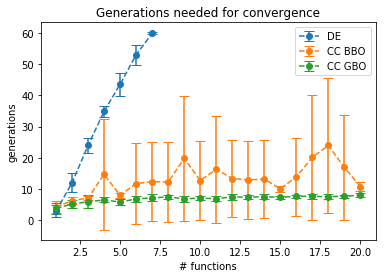

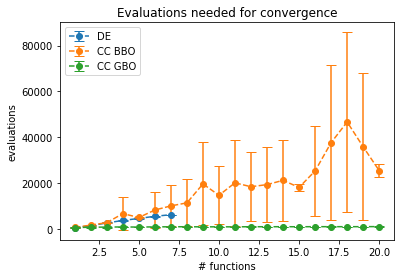

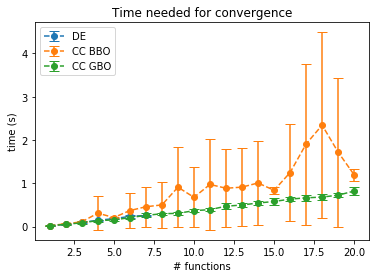

In [21]:
### Initialize some settings of the experiment
sphere = get_sphere()
subL = 1
VTR = pow(10, -5)
# repeat each experiment N times
N = 15
# number of functions is increasing
Kmax = 20
Ks = list(range(1, Kmax+1))
pop_size = 100
max_generations = 60
# arguments for the DE
args = {"population_size": pop_size, "crossover_probability": 0.25,
                     "f_weight": 0.1}
### Create arrays to store all of the partial results for later plotting
times = np.zeros((len(Ks), N))
times_gbo = np.zeros((len(Ks), N))
times_bbo = np.zeros((len(Ks), N))
evals = np.zeros((len(Ks), N))
evals_gbo = np.zeros((len(Ks), N))
evals_bbo = np.zeros((len(Ks), N))
gens = np.zeros((len(Ks), N))
gens_gbo = np.zeros((len(Ks), N))
gens_bbo = np.zeros((len(Ks), N))
# to save some time, check up until what point the algorithms have been solving the problems,
# so that we don't run the harder experiments if they failed the easier ones
# also only plot up until the first big failure
success_idx = 0
success_idx_gbo = 0
success_idx_bbo = 0
for idx, K in enumerate(Ks):
    print("K {}".format(K))
    ### Input for the GBO and BBO classes
    functions = [sphere]*K
    LB = [-3]*K*subL
    UB = [2]*K*subL
    gas = [DE]*K
    train_partition = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    input_spaces = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    ga_arguments = [args]*K

    print("\t", end="")
    for exp in range(N):
        print(exp, end=" ")
        ### normal black box optimization
        # only run if it has been keeping up
        if success_idx == idx:
            de = DE(sphere, K*subL, lower_bounds=LB[0], upper_bounds=UB[0], 
                    goal_fitness=VTR, max_generations=max_generations, **args)
            start = time()
            while not de.has_converged():
                de.evolve()
            times[idx, exp] = time() - start
            evals[idx, exp] = de._evaluations
            gens[idx, exp] = de._generations
        ### cooperative coevolution with gray box optimization
        # only run if it has been keeping up
        if success_idx_gbo == idx:
            gbo = GrayBoxOptimizer(functions = functions,
                              input_spaces = input_spaces,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = ga_arguments,
                              max_generations = max_generations,
                              goal_fitness = VTR)
            start = time()
            while not gbo.has_converged():
                gbo.evolve()
            times_gbo[idx, exp] = time() - start
            evals_gbo[idx, exp] = gbo.get_evaluations()
            gens_gbo[idx, exp] = gbo._generations
        ### cooperative coevolution with black box optimization
        # only run if it has been keeping up
        if success_idx_bbo == idx:
            bbo = BlackBoxOptimizer(function = sphere,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = ga_arguments,
                              max_generations = max_generations,
                              goal_fitness = VTR)
            start = time()
            while not bbo.has_converged():
                bbo.evolve()
            times_bbo[idx, exp] = time() - start
            evals_bbo[idx, exp] = bbo.get_evaluations()
            gens_bbo[idx, exp] = bbo._generations
            
    ### check which of the algorithms were able to keep up
    if success_idx == idx:
        # if the avg number of generations used was below 95% of the max,
        # run this algorithm in the next experiment
        if np.mean(gens[idx, :]) <= 0.95*max_generations:
            success_idx += 1
        else:
            print("### Dropping standard DE ###")
    if success_idx_gbo == idx:
        if np.mean(gens_gbo[idx, :]) <= 0.95*max_generations:
            success_idx_gbo += 1
        else:
            print("### Dropping GBO ###")
    if success_idx_bbo == idx:
        if np.mean(gens_bbo[idx, :]) <= 0.95*max_generations:
            success_idx_bbo += 1
        else:
            print("### Dropping BBO ###")
    print()

si = success_idx+1
sig = success_idx_gbo+1
sib = success_idx_bbo+1
                
plt.figure(1)
gens_means = np.mean(gens[:si], axis=-1)
gens_errs = np.std(gens[:si], axis=-1)
plt.errorbar(Ks[:si], gens_means, yerr=gens_errs, fmt="--o", capsize=5)
gens_bbo_means = np.mean(gens_bbo[:sib], axis=-1)
gens_bbo_errs = np.std(gens_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], gens_bbo_means, yerr=gens_bbo_errs, fmt="--o", capsize=5)
gens_gbo_means = np.mean(gens_gbo[:sig], axis=-1)
gens_gbo_errs = np.std(gens_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], gens_gbo_means, yerr=gens_gbo_errs, fmt="--o", capsize=5)
plt.title("Generations needed for convergence")
plt.xlabel("# functions")
plt.ylabel("generations")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.figure(2)
evals_means = np.mean(evals[:si], axis=-1)
evals_errs = np.std(evals[:si], axis=-1)
plt.errorbar(Ks[:si], evals_means, yerr=evals_errs, fmt="--o", capsize=5)
evals_bbo_means = np.mean(evals_bbo[:sib], axis=-1)
evals_bbo_errs = np.std(evals_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], evals_bbo_means, yerr=evals_bbo_errs, fmt="--o", capsize=5)
evals_gbo_means = np.mean(evals_gbo[:sig], axis=-1)
evals_gbo_errs = np.std(evals_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], evals_gbo_means, yerr=evals_gbo_errs, fmt="--o", capsize=5)
plt.title("Evaluations needed for convergence")
plt.xlabel("# functions")
plt.ylabel("evaluations")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.figure(3)
times_means = np.mean(times[:si], axis=-1)
times_errs = np.std(times[:si], axis=-1)
plt.errorbar(Ks[:si], times_means, yerr=times_errs, fmt="--o", capsize=5)
times_bbo_means = np.mean(times_bbo[:sib], axis=-1)
times_bbo_errs = np.std(times_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], times_bbo_means, yerr=times_bbo_errs, fmt="--o", capsize=5)
times_gbo_means = np.mean(times_gbo[:sig], axis=-1)
times_gbo_errs = np.std(times_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], times_gbo_means, yerr=times_gbo_errs, fmt="--o", capsize=5)
plt.title("Time needed for convergence")
plt.xlabel("# functions")
plt.ylabel("time (s)")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.show()

## Repeat experiments above
Decrease maximum generations even more

Increment the number of functions in a different way

K 1
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 2
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 4
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 8
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ### Dropping standard DE ###

K 10
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 20
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 40
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 80
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 100
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
K 200
	0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 


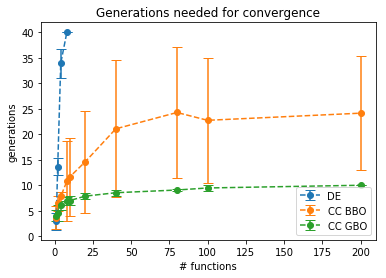

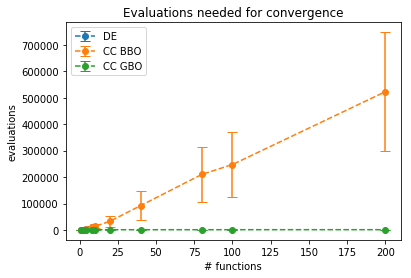

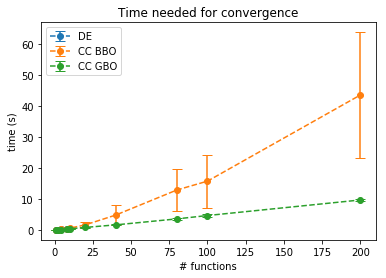

In [22]:
### Initialize some settings of the experiment
sphere = get_sphere()
subL = 1
VTR = pow(10, -5)
# repeat each experiment N times
N = 15
# number of functions is increasing
Ks = [1, 2, 4, 8, 10, 20, 40, 80, 100, 200]
pop_size = 100
max_generations = 40
# arguments for the DE
args = {"population_size": pop_size, "crossover_probability": 0.25,
                     "f_weight": 0.1}
### Create arrays to store all of the partial results for later plotting
times = np.zeros((len(Ks), N))
times_gbo = np.zeros((len(Ks), N))
times_bbo = np.zeros((len(Ks), N))
evals = np.zeros((len(Ks), N))
evals_gbo = np.zeros((len(Ks), N))
evals_bbo = np.zeros((len(Ks), N))
gens = np.zeros((len(Ks), N))
gens_gbo = np.zeros((len(Ks), N))
gens_bbo = np.zeros((len(Ks), N))
# to save some time, check up until what point the algorithms have been solving the problems,
# so that we don't run the harder experiments if they failed the easier ones
# also only plot up until the first big failure
success_idx = 0
success_idx_gbo = 0
success_idx_bbo = 0
for idx, K in enumerate(Ks):
    print("K {}".format(K))
    ### Input for the GBO and BBO classes
    functions = [sphere]*K
    LB = [-3]*K*subL
    UB = [2]*K*subL
    gas = [DE]*K
    train_partition = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    input_spaces = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    ga_arguments = [args]*K

    print("\t", end="")
    for exp in range(N):
        print(exp, end=" ")
        ### normal black box optimization
        # only run if it has been keeping up
        if success_idx == idx:
            de = DE(sphere, K*subL, lower_bounds=LB[0], upper_bounds=UB[0], 
                    goal_fitness=VTR, max_generations=max_generations, **args)
            start = time()
            while not de.has_converged():
                de.evolve()
            times[idx, exp] = time() - start
            evals[idx, exp] = de._evaluations
            gens[idx, exp] = de._generations
        ### cooperative coevolution with gray box optimization
        # only run if it has been keeping up
        if success_idx_gbo == idx:
            gbo = GrayBoxOptimizer(functions = functions,
                              input_spaces = input_spaces,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = ga_arguments,
                              max_generations = max_generations,
                              goal_fitness = VTR)
            start = time()
            while not gbo.has_converged():
                gbo.evolve()
            times_gbo[idx, exp] = time() - start
            evals_gbo[idx, exp] = gbo.get_evaluations()
            gens_gbo[idx, exp] = gbo._generations
        ### cooperative coevolution with black box optimization
        # only run if it has been keeping up
        if success_idx_bbo == idx:
            bbo = BlackBoxOptimizer(function = sphere,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = ga_arguments,
                              max_generations = max_generations,
                              goal_fitness = VTR)
            start = time()
            while not bbo.has_converged():
                bbo.evolve()
            times_bbo[idx, exp] = time() - start
            evals_bbo[idx, exp] = bbo.get_evaluations()
            gens_bbo[idx, exp] = bbo._generations
            
    ### check which of the algorithms were able to keep up
    if success_idx == idx:
        # if the avg number of generations used was below 95% of the max,
        # run this algorithm in the next experiment
        if np.mean(gens[idx, :]) <= 0.95*max_generations:
            success_idx += 1
        else:
            print("### Dropping standard DE ###")
    if success_idx_gbo == idx:
        if np.mean(gens_gbo[idx, :]) <= 0.95*max_generations:
            success_idx_gbo += 1
        else:
            print("### Dropping GBO ###")
    if success_idx_bbo == idx:
        if np.mean(gens_bbo[idx, :]) <= 0.95*max_generations:
            success_idx_bbo += 1
        else:
            print("### Dropping BBO ###")
    print()

si = success_idx+1
sig = success_idx_gbo+1
sib = success_idx_bbo+1
                
plt.figure(1)
gens_means = np.mean(gens[:si], axis=-1)
gens_errs = np.std(gens[:si], axis=-1)
plt.errorbar(Ks[:si], gens_means, yerr=gens_errs, fmt="--o", capsize=5)
gens_bbo_means = np.mean(gens_bbo[:sib], axis=-1)
gens_bbo_errs = np.std(gens_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], gens_bbo_means, yerr=gens_bbo_errs, fmt="--o", capsize=5)
gens_gbo_means = np.mean(gens_gbo[:sig], axis=-1)
gens_gbo_errs = np.std(gens_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], gens_gbo_means, yerr=gens_gbo_errs, fmt="--o", capsize=5)
plt.title("Generations needed for convergence")
plt.xlabel("# functions")
plt.ylabel("generations")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.figure(2)
evals_means = np.mean(evals[:si], axis=-1)
evals_errs = np.std(evals[:si], axis=-1)
plt.errorbar(Ks[:si], evals_means, yerr=evals_errs, fmt="--o", capsize=5)
evals_bbo_means = np.mean(evals_bbo[:sib], axis=-1)
evals_bbo_errs = np.std(evals_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], evals_bbo_means, yerr=evals_bbo_errs, fmt="--o", capsize=5)
evals_gbo_means = np.mean(evals_gbo[:sig], axis=-1)
evals_gbo_errs = np.std(evals_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], evals_gbo_means, yerr=evals_gbo_errs, fmt="--o", capsize=5)
plt.title("Evaluations needed for convergence")
plt.xlabel("# functions")
plt.ylabel("evaluations")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.figure(3)
times_means = np.mean(times[:si], axis=-1)
times_errs = np.std(times[:si], axis=-1)
plt.errorbar(Ks[:si], times_means, yerr=times_errs, fmt="--o", capsize=5)
times_bbo_means = np.mean(times_bbo[:sib], axis=-1)
times_bbo_errs = np.std(times_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], times_bbo_means, yerr=times_bbo_errs, fmt="--o", capsize=5)
times_gbo_means = np.mean(times_gbo[:sig], axis=-1)
times_gbo_errs = np.std(times_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], times_gbo_means, yerr=times_gbo_errs, fmt="--o", capsize=5)
plt.title("Time needed for convergence")
plt.xlabel("# functions")
plt.ylabel("time (s)")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.show()

# Compare normal BBO with CC BBO and CC GBO using DE for rosenbrock
species of length 2
population size 200
max generations 100

## Try to find DE settings that work for rosenbrock

In [158]:
func = get_rosenbrock()
for _ in range(10):
    de = DE(func, 2, lower_bounds=-3, upper_bounds=2, 
                    goal_fitness=pow(10, -4), 
                    population_size=200, max_generations=100,
                    crossover_probability=0.33, f_weight=0.05)
    while not de.has_converged():
        de.evolve()
    print(de._generations)
    print(de.get_best_fitness(1))
    print(de.get_best_genotypes(1))

40
[8.19873863e-05]
[[0.99101235 0.98221545]]
100
[0.00017449]
[[0.98680351 0.97372228]]
22
[7.8520208e-05]
[[1.00687747 1.01324349]]
20
[9.31022724e-05]
[[1.00961572 1.01940391]]
38
[7.10349551e-05]
[[0.99284931 0.98619587]]
24
[4.07299488e-05]
[[0.99745873 0.9943385 ]]
32
[1.44726192e-05]
[[1.00169085 1.00304376]]
34
[3.62345538e-05]
[[0.99469912 0.98914112]]
34
[8.90553507e-05]
[[1.00907894 1.01849777]]
35
[6.74543886e-05]
[[0.99274359 0.98592453]]


K 1
	0 1 2 3 4 5 6 7 8 9 
K 2
	0 1 2 3 4 5 6 7 8 9 ### Dropping standard DE ###

K 3
	0 1 2 3 4 5 6 7 8 9 
K 4
	0 1 2 3 4 5 6 7 8 9 
K 5
	0 1 2 3 4 5 6 7 8 9 
K 6
	0 1 2 3 4 5 6 7 8 9 
K 7
	0 1 2 3 4 5 6 7 8 9 ### Dropping BBO ###

K 8
	0 1 2 3 4 5 6 7 8 9 
K 9
	0 1 2 3 4 5 6 7 8 9 
K 10
	0 1 2 3 4 5 6 7 8 9 ### Dropping GBO ###

K 11
	0 1 2 3 4 5 6 7 8 9 
K 12
	0 1 2 3 4 5 6 7 8 9 
K 13
	0 1 2 3 4 5 6 7 8 9 
K 14
	0 1 2 3 4 5 6 7 8 9 
K 15
	0 1 2 3 4 5 6 7 8 9 
K 16
	0 1 2 3 4 5 6 7 8 9 
K 17
	0 1 2 3 4 5 6 7 8 9 
K 18
	0 1 2 3 4 5 6 7 8 9 
K 19
	0 1 2 3 4 5 6 7 8 9 
K 20
	0 1 2 3 4 5 6 7 8 9 


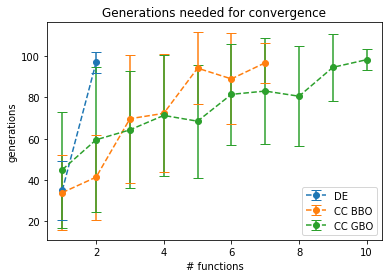

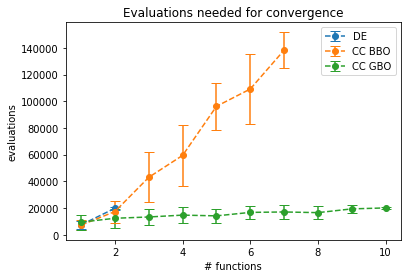

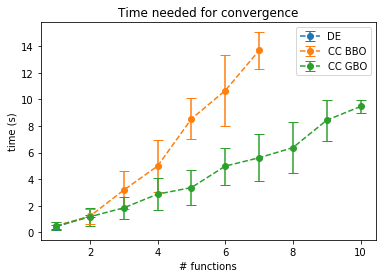

In [161]:
### Initialize some settings of the experiment
func = get_rosenbrock()
subL = 2
VTR = pow(10, -4)
# repeat each experiment N times
N = 10
# number of functions is increasing
Kmax = 20
Ks = list(range(1, Kmax+1))
pop_size = 200
max_generations = 100
# arguments for the DE
args = {"population_size": pop_size, "crossover_probability": 0.33,
                     "f_weight": 0.05}
### Create arrays to store all of the partial results for later plotting
times = np.zeros((len(Ks), N))
times_gbo = np.zeros((len(Ks), N))
times_bbo = np.zeros((len(Ks), N))
evals = np.zeros((len(Ks), N))
evals_gbo = np.zeros((len(Ks), N))
evals_bbo = np.zeros((len(Ks), N))
gens = np.zeros((len(Ks), N))
gens_gbo = np.zeros((len(Ks), N))
gens_bbo = np.zeros((len(Ks), N))
# to save some time, check up until what point the algorithms have been solving the problems,
# so that we don't run the harder experiments if they failed the easier ones
# also only plot up until the first big failure
success_idx = 0
success_idx_gbo = 0
success_idx_bbo = 0
for idx, K in enumerate(Ks):
    print("K {}".format(K))
    ### Input for the GBO and BBO classes
    functions = [func]*K
    LB = [-3]*K*subL
    UB = [2]*K*subL
    gas = [DE]*K
    train_partition = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    input_spaces = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    ga_arguments = [args]*K

    print("\t", end="")
    for exp in range(N):
        print(exp, end=" ")
        ### normal black box optimization
        # only run if it has been keeping up
        F = lambda x: np.sum([func(x[i*subL:(i+1)*subL]) for i in range(K)])
        if success_idx == idx:
            de = DE(F, K*subL, lower_bounds=LB[0], upper_bounds=UB[0], 
                    goal_fitness=VTR, max_generations=max_generations, **args)
            start = time()
            while not de.has_converged():
                de.evolve()
            times[idx, exp] = time() - start
            evals[idx, exp] = de._evaluations
            gens[idx, exp] = de._generations
        ### cooperative coevolution with gray box optimization
        # only run if it has been keeping up
        if success_idx_gbo == idx:
            gbo = GrayBoxOptimizer(functions = functions,
                              input_spaces = input_spaces,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = ga_arguments,
                              max_generations = max_generations,
                              goal_fitness = VTR)
            start = time()
            while not gbo.has_converged():
                gbo.evolve()
            times_gbo[idx, exp] = time() - start
            evals_gbo[idx, exp] = gbo.get_evaluations()
            gens_gbo[idx, exp] = gbo._generations
        ### cooperative coevolution with black box optimization
        # only run if it has been keeping up
        if success_idx_bbo == idx:
            bbo = BlackBoxOptimizer(function = F,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = ga_arguments,
                              max_generations = max_generations,
                              goal_fitness = VTR)
            start = time()
            while not bbo.has_converged():
                bbo.evolve()
            times_bbo[idx, exp] = time() - start
            evals_bbo[idx, exp] = bbo.get_evaluations()
            gens_bbo[idx, exp] = bbo._generations
            
    ### check which of the algorithms were able to keep up
    if success_idx == idx:
        # if the avg number of generations used was below 95% of the max,
        # run this algorithm in the next experiment
        if np.mean(gens[idx, :]) <= 0.95*max_generations:
            success_idx += 1
        else:
            print("### Dropping standard DE ###")
    if success_idx_gbo == idx:
        if np.mean(gens_gbo[idx, :]) <= 0.95*max_generations:
            success_idx_gbo += 1
        else:
            print("### Dropping GBO ###")
    if success_idx_bbo == idx:
        if np.mean(gens_bbo[idx, :]) <= 0.95*max_generations:
            success_idx_bbo += 1
        else:
            print("### Dropping BBO ###")
    print()

si = success_idx+1
sig = success_idx_gbo+1
sib = success_idx_bbo+1
                
plt.figure(1)
gens_means = np.mean(gens[:si], axis=-1)
gens_errs = np.std(gens[:si], axis=-1)
plt.errorbar(Ks[:si], gens_means, yerr=gens_errs, fmt="--o", capsize=5)
gens_bbo_means = np.mean(gens_bbo[:sib], axis=-1)
gens_bbo_errs = np.std(gens_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], gens_bbo_means, yerr=gens_bbo_errs, fmt="--o", capsize=5)
gens_gbo_means = np.mean(gens_gbo[:sig], axis=-1)
gens_gbo_errs = np.std(gens_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], gens_gbo_means, yerr=gens_gbo_errs, fmt="--o", capsize=5)
plt.title("Generations needed for convergence")
plt.xlabel("# functions")
plt.ylabel("generations")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.figure(2)
evals_means = np.mean(evals[:si], axis=-1)
evals_errs = np.std(evals[:si], axis=-1)
plt.errorbar(Ks[:si], evals_means, yerr=evals_errs, fmt="--o", capsize=5)
evals_bbo_means = np.mean(evals_bbo[:sib], axis=-1)
evals_bbo_errs = np.std(evals_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], evals_bbo_means, yerr=evals_bbo_errs, fmt="--o", capsize=5)
evals_gbo_means = np.mean(evals_gbo[:sig], axis=-1)
evals_gbo_errs = np.std(evals_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], evals_gbo_means, yerr=evals_gbo_errs, fmt="--o", capsize=5)
plt.title("Evaluations needed for convergence")
plt.xlabel("# functions")
plt.ylabel("evaluations")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.figure(3)
times_means = np.mean(times[:si], axis=-1)
times_errs = np.std(times[:si], axis=-1)
plt.errorbar(Ks[:si], times_means, yerr=times_errs, fmt="--o", capsize=5)
times_bbo_means = np.mean(times_bbo[:sib], axis=-1)
times_bbo_errs = np.std(times_bbo[:sib], axis=-1)
plt.errorbar(Ks[:sib], times_bbo_means, yerr=times_bbo_errs, fmt="--o", capsize=5)
times_gbo_means = np.mean(times_gbo[:sig], axis=-1)
times_gbo_errs = np.std(times_gbo[:sig], axis=-1)
plt.errorbar(Ks[:sig], times_gbo_means, yerr=times_gbo_errs, fmt="--o", capsize=5)
plt.title("Time needed for convergence")
plt.xlabel("# functions")
plt.ylabel("time (s)")
plt.legend(["DE", "CC BBO", "CC GBO"])

plt.show()

# From here onwards, I don't really know what to do with this...
# Will be deleted soon, but I might want to copy & pasta some of the code below, before I do that

## (B) Sphere with 5 inputs, increase number of functions

### Differential Evolution, PSO and Evolution Strategies

<class 'differential_evolution.DifferentialEvolution'>
K 1
K 2
K 3
<class 'particle_swarm_optimization.ParticleSwarmOptimization'>
K 1
K 2
K 3
<class 'evolution_strategies.EvolutionStrategies'>
K 1
K 2
K 3


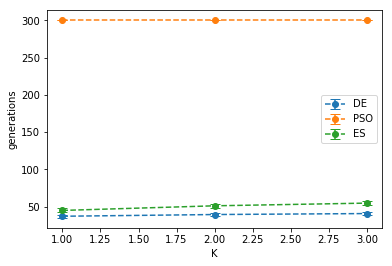

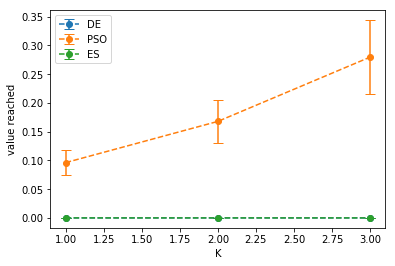

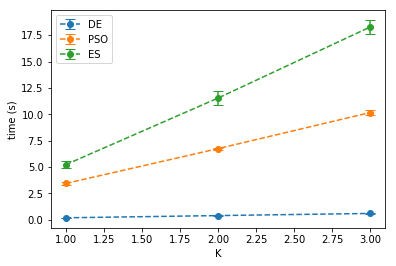

In [3]:
sphere = get_sphere()
subL = 5
VTR = pow(10, -4)
# repeat each experiment N times
N = 10
# vary number of functions up to kmax
Kmax = 3
Ks = list(range(1, Kmax+1))

GAs = [DE, PSO, ES]
ga_arguments = [
    {"population_size": 100, "crossover_probability": 0.25,
                     "f_weight": 0.1},
    {"population_size": 100, "interaction": PSOInteractions.FIPS},
    {"population_size": 100, "offspring_size": 700}
]
for GA, args in zip(GAs, ga_arguments):
    print(GA)
    # save the results, each row for a different K
    times = np.zeros((Kmax, N))
    generations = np.zeros((Kmax, N))
    values_reached = np.zeros((Kmax, N))
    for K in Ks:
        print("K {}".format(K))
        functions = [sphere]*K
        LB = [-3]*K*subL
        UB = [2]*K*subL
        gas = [GA]*K
        train_partition = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
        input_spaces = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
        arguments = [args]*K

        for exp in range(N):
            gbo = GrayBoxOptimizer(functions = functions,
                              input_spaces = input_spaces,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = arguments,
                              max_generations = 300,
                              goal_fitness = VTR)
            start = time()
            while not gbo.has_converged():
                gbo.evolve()
            times[K-1, exp] = time() - start
            generations[K-1, exp] = gbo._generations
            values_reached[K-1, exp] = gbo.get_elite_fitness()

    plt.figure(1)
    generations_means = np.mean(generations, axis=-1)
    generations_errs = np.std(generations, axis=-1)
    plt.errorbar(Ks, generations_means, yerr=generations_errs, fmt="--o", capsize=5)

    plt.figure(2)
    vals_means = np.mean(values_reached, axis=-1)
    vals_errs = np.std(values_reached, axis=-1)
    plt.errorbar(Ks, vals_means, yerr=vals_errs, fmt="--o", capsize=5)
    
    plt.figure(3)
    times_means = np.mean(times, axis=-1)
    times_errs = np.std(times, axis=-1)
    plt.errorbar(Ks, times_means, yerr=times_errs, fmt="--o", capsize=5)
    
plt.figure(1)
plt.xlabel("K")
plt.ylabel("generations")
plt.legend(["DE", "PSO", "ES"])

plt.figure(2)
plt.xlabel("K")
plt.ylabel("value reached")
plt.legend(["DE", "PSO", "ES"])

plt.figure(3)
plt.xlabel("K")
plt.ylabel("time (s)")
plt.legend(["DE", "PSO", "ES"])

plt.show()

### Differential Evolution and Particle Swarm Optimization

<class 'differential_evolution.DifferentialEvolution'>
K 1
K 2
K 3
K 4
K 5
K 6
K 7
K 8
K 9
K 10
K 11
K 12
K 13
K 14
K 15
K 16
K 17
K 18
K 19
K 20
<class 'particle_swarm_optimization.ParticleSwarmOptimization'>
K 1
K 2
K 3
K 4
K 5
K 6
K 7
K 8
K 9
K 10
K 11
K 12
K 13
K 14
K 15
K 16
K 17
K 18
K 19
K 20


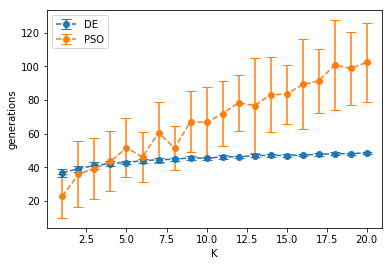

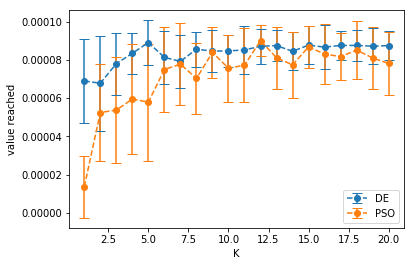

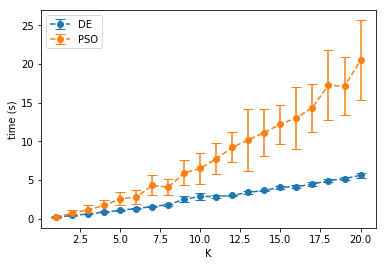

In [29]:
sphere = get_sphere()
subL = 5
VTR = pow(10, -4)
# repeat each experiment N times
N = 20
# vary number of functions up to kmax
Kmax = 20
Ks = list(range(1, Kmax+1))

GAs = [DE, PSO]
ga_arguments = [
    {"population_size": 100, "crossover_probability": 0.25,
                     "f_weight": 0.1},
    {"population_size": 100, "interaction": PSOInteractions.FIPS}
]
for GA, args in zip(GAs, ga_arguments):
    print(GA)
    # save the results, each row for a different K
    times = np.zeros((Kmax, N))
    generations = np.zeros((Kmax, N))
    values_reached = np.zeros((Kmax, N))
    for K in Ks:
        print("K {}".format(K))
        functions = [sphere]*K
        LB = [-3]*K*subL
        UB = [2]*K*subL
        gas = [GA]*K
        train_partition = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
        input_spaces = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
        arguments = [args]*K

        for exp in range(N):
            gbo = GrayBoxOptimizer(functions = functions,
                              input_spaces = input_spaces,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = arguments,
                              max_generations = 300,
                              goal_fitness = VTR)
            start = time()
            while not gbo.has_converged():
                gbo.evolve()
            times[K-1, exp] = time() - start
            generations[K-1, exp] = gbo._generations
            values_reached[K-1, exp] = gbo.get_elite_fitness()

    plt.figure(1)
    generations_means = np.mean(generations, axis=-1)
    generations_errs = np.std(generations, axis=-1)
    plt.errorbar(Ks, generations_means, yerr=generations_errs, fmt="--o", capsize=5)

    plt.figure(2)
    vals_means = np.mean(values_reached, axis=-1)
    vals_errs = np.std(values_reached, axis=-1)
    plt.errorbar(Ks, vals_means, yerr=vals_errs, fmt="--o", capsize=5)
    
    plt.figure(3)
    times_means = np.mean(times, axis=-1)
    times_errs = np.std(times, axis=-1)
    plt.errorbar(Ks, times_means, yerr=times_errs, fmt="--o", capsize=5)
    
plt.figure(1)
plt.xlabel("K")
plt.ylabel("generations")
plt.legend(["DE", "PSO"])

plt.figure(2)
plt.xlabel("K")
plt.ylabel("value reached")
plt.legend(["DE", "PSO"])

plt.figure(3)
plt.xlabel("K")
plt.ylabel("time (s)")
plt.legend(["DE", "PSO"])

plt.show()

## (C) 5 sphere functions, increase input size

###  Differential Evolution, Particle Swarm Optimization

<class 'differential_evolution.DifferentialEvolution'>
subL 1
subL 2
subL 3
subL 4
subL 6
subL 8
subL 12
subL 16
subL 24
subL 32
subL 48
subL 64
<class 'particle_swarm_optimization.ParticleSwarmOptimization'>
subL 1
subL 2
subL 3
subL 4
subL 6
subL 8
subL 12
subL 16
subL 24
subL 32
subL 48
subL 64


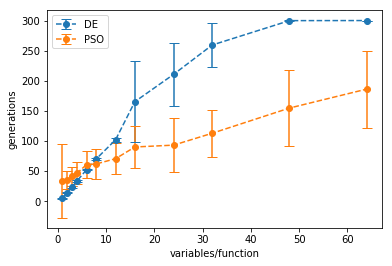

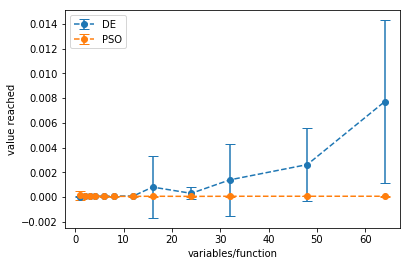

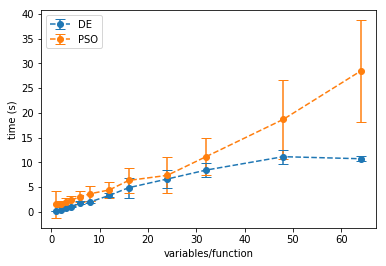

In [31]:
sphere = get_sphere()
subLs = [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64]
VTR = pow(10, -4)
# repeat each experiment N times
N = 20
# number of functions is fixed
K = 5
Ks = list(range(1, Kmax+1))

GAs = [DE, PSO]
ga_arguments = [
    {"population_size": 100, "crossover_probability": 0.25,
                     "f_weight": 0.1},
    {"population_size": 100, "interaction": PSOInteractions.FIPS}
]
for GA, args in zip(GAs, ga_arguments):
    print(GA)
    # save the results, each row for a different K
    times = np.zeros((len(subLs), N))
    generations = np.zeros((len(subLs), N))
    values_reached = np.zeros((len(subLs), N))
    for idx, subL in enumerate(subLs):
        print("subL {}".format(subL))
        functions = [sphere]*K
        LB = [-3]*K*subL
        UB = [2]*K*subL
        gas = [GA]*K
        train_partition = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
        input_spaces = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
        arguments = [args]*K

        for exp in range(N):
            gbo = GrayBoxOptimizer(functions = functions,
                              input_spaces = input_spaces,
                              train_partition = train_partition,
                              lower_bounds = LB, upper_bounds = UB,
                              genetic_algorithms = gas,
                              genetic_algorithm_arguments = arguments,
                              max_generations = 300,
                              goal_fitness = VTR)
            start = time()
            while not gbo.has_converged():
                gbo.evolve()
            times[idx, exp] = time() - start
            generations[idx, exp] = gbo._generations
            values_reached[idx, exp] = gbo.get_elite_fitness()

    plt.figure(1)
    generations_means = np.mean(generations, axis=-1)
    generations_errs = np.std(generations, axis=-1)
    plt.errorbar(subLs, generations_means, yerr=generations_errs, fmt="--o", capsize=5)

    plt.figure(2)
    vals_means = np.mean(values_reached, axis=-1)
    vals_errs = np.std(values_reached, axis=-1)
    plt.errorbar(subLs, vals_means, yerr=vals_errs, fmt="--o", capsize=5)
    
    plt.figure(3)
    times_means = np.mean(times, axis=-1)
    times_errs = np.std(times, axis=-1)
    plt.errorbar(subLs, times_means, yerr=times_errs, fmt="--o", capsize=5)
    
plt.figure(1)
plt.xlabel("variables/function")
plt.ylabel("generations")
plt.legend(["DE", "PSO"])

plt.figure(2)
plt.xlabel("variables/function")
plt.ylabel("value reached")
plt.legend(["DE", "PSO"])

plt.figure(3)
plt.xlabel("variables/function")
plt.ylabel("time (s)")
plt.legend(["DE", "PSO"])

plt.show()

### DE, GBO vs BBO

subL 1
subL 2
subL 3
subL 4
subL 6
subL 8
subL 12
subL 16
subL 24
subL 32
subL 48
subL 64


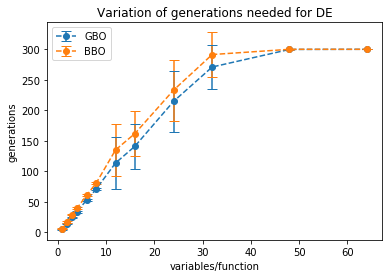

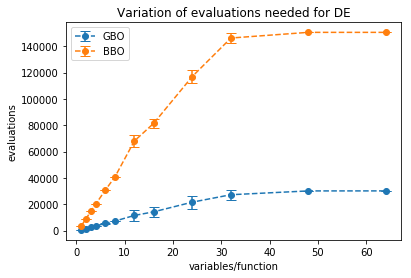

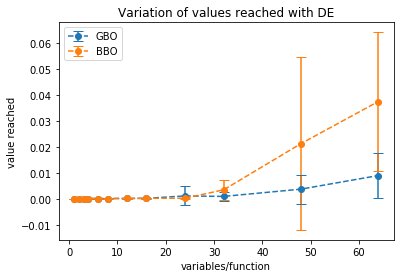

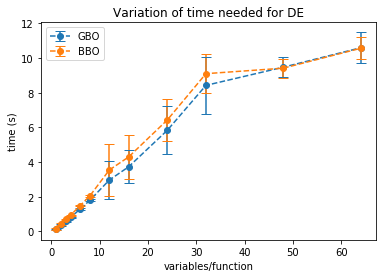

In [8]:
sphere = get_sphere()
subLs = [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64]
VTR = pow(10, -4)
# repeat each experiment N times
N = 20
# number of functions is fixed
K = 5
Ks = list(range(1, Kmax+1))

args = {"population_size": 100, "crossover_probability": 0.25,
                     "f_weight": 0.1}
# save the results, each row for a different L
times = np.zeros((len(subLs), N))
times_bbo = np.zeros((len(subLs), N))
evaluations = np.zeros((len(subLs), N))
evaluations_bbo = np.zeros((len(subLs), N))
generations = np.zeros((len(subLs), N))
generations_bbo = np.zeros((len(subLs), N))
values_reached = np.zeros((len(subLs), N))
values_reached_bbo = np.zeros((len(subLs), N))
for idx, subL in enumerate(subLs):
    print("subL {}".format(subL))
    functions = [sphere]*K
    LB = [-3]*K*subL
    UB = [2]*K*subL
    gas = [DE]*K
    train_partition = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    input_spaces = [list(range(i*subL, (i+1)*subL)) for i in range(K)]
    arguments = [args]*K

    for exp in range(N):
        gbo = GrayBoxOptimizer(functions = functions,
                          input_spaces = input_spaces,
                          train_partition = train_partition,
                          lower_bounds = LB, upper_bounds = UB,
                          genetic_algorithms = gas,
                          genetic_algorithm_arguments = arguments,
                          max_generations = 300,
                          goal_fitness = VTR)
        start = time()
        while not gbo.has_converged():
            gbo.evolve()
        times[idx, exp] = time() - start
        evaluations[idx, exp] = gbo.get_evaluations()
        generations[idx, exp] = gbo._generations
        values_reached[idx, exp] = gbo.get_elite_fitness()
        
        bbo = BlackBoxOptimizer(function = sphere,
                          train_partition = train_partition,
                          lower_bounds = LB, upper_bounds = UB,
                          genetic_algorithms = gas,
                          genetic_algorithm_arguments = arguments,
                          max_generations = 300,
                          goal_fitness = VTR)
        start = time()
        while not bbo.has_converged():
            bbo.evolve()
        times_bbo[idx, exp] = time() - start
        evaluations_bbo[idx, exp] = bbo.get_evaluations()
        generations_bbo[idx, exp] = bbo._generations
        values_reached_bbo[idx, exp] = bbo.get_elite_fitness()

plt.figure(1)
generations_means = np.mean(generations, axis=-1)
generations_errs = np.std(generations, axis=-1)
plt.errorbar(subLs, generations_means, yerr=generations_errs, fmt="--o", capsize=5)
gens_bbo_means = np.mean(generations_bbo, axis=-1)
gens_bbo_errs = np.std(generations, axis=-1)
plt.errorbar(subLs, gens_bbo_means, yerr=gens_bbo_errs, fmt="--o", capsize=5)
plt.title("Variation of generations needed for DE")
plt.xlabel("variables/function")
plt.ylabel("generations")
plt.legend(["GBO", "BBO"])

plt.figure(2)
evaluations_means = np.mean(evaluations, axis=-1)
evaluations_errs = np.std(evaluations, axis=-1)
plt.errorbar(subLs, evaluations_means, yerr=evaluations_errs, fmt="--o", capsize=5)
evals_bbo_means = np.mean(evaluations_bbo, axis=-1)
evals_bbo_errs = np.std(evaluations, axis=-1)
plt.errorbar(subLs, evals_bbo_means, yerr=evals_bbo_errs, fmt="--o", capsize=5)
plt.title("Variation of evaluations needed for DE")
plt.xlabel("variables/function")
plt.ylabel("evaluations")
plt.legend(["GBO", "BBO"])

plt.figure(3)
vals_means = np.mean(values_reached, axis=-1)
vals_errs = np.std(values_reached, axis=-1)
plt.errorbar(subLs, vals_means, yerr=vals_errs, fmt="--o", capsize=5)
vals_bbo_means = np.mean(values_reached_bbo, axis=-1)
vals_bbo_errs = np.std(values_reached_bbo, axis=-1)
plt.errorbar(subLs, vals_bbo_means, yerr=vals_bbo_errs, fmt="--o", capsize=5)
plt.title("Variation of values reached with DE")
plt.xlabel("variables/function")
plt.ylabel("value reached")
plt.legend(["GBO", "BBO"])

plt.figure(4)
times_means = np.mean(times, axis=-1)
times_errs = np.std(times, axis=-1)
plt.errorbar(subLs, times_means, yerr=times_errs, fmt="--o", capsize=5)
times_bbo_means = np.mean(times_bbo, axis=-1)
times_bbo_errs = np.std(times_bbo, axis=-1)
plt.errorbar(subLs, times_bbo_means, yerr=times_bbo_errs, fmt="--o", capsize=5)
plt.title("Variation of time needed for DE")
plt.xlabel("variables/function")
plt.ylabel("time (s)")
plt.legend(["GBO", "BBO"])

plt.show()